In [1]:
from pandas import read_csv
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from keras.optimizers import Adam
from keras.layers import Dropout

data = pd.read_csv("clean_indonesia_data.csv")

In [2]:
data

,date,cases,vaccin,fully_vaccin
0,2020-03-02,2.0,0.0,0.0
1,2020-03-03,0.0,0.0,0.0
2,2020-03-04,0.0,0.0,0.0
3,2020-03-05,0.0,0.0,0.0
4,2020-03-06,2.0,0.0,0.0
...,...,...,...,...
598,2021-10-21,633.0,110406777.0,65173148.0
599,2021-10-22,760.0,111496041.0,66316667.0
600,2021-10-23,802.0,112271928.0,67165732.0
601,2021-10-24,623.0,113032768.0,67915440.0


In [3]:
def pemilihan(x, y):
    x = x.transpose()
    x = x.tolist()
    y = y.tolist()
    for i in range (1, len(x), 1):
        if i == 1:
            del x[i][len(x[i])-1]
            x[i].insert(0, 0)
        else:
            for j in range (0,i,1):
                del x[i][len(x[i])-1]
                x[i].insert(0, 0)
                
    x = np.array(x)
    x = x.transpose()
    #x = x.tolist()
    
    for i in range (len(x)):
        for j in range (len(x[0])):
            x[i][j] =  x[i][j]-y[i]
    
    x_abs = np.copy(x)
    for i in range (len(x)):
        for j in range (len(x[0])):
            x_abs[i][j] = abs(x_abs[i][j])
    
    best_predict = []
    for i in range (len(x)):
        best_predict.append(min(x_abs[i]))
    
    for i in range(len(x)):
        for j in range (len(x[i])):
            if best_predict[i] == abs(x[i][j]):
                best_predict[i] = x[i][j] + y[i]
    
    return best_predict

In [4]:
del data['date']
del data['vaccin']
del data['fully_vaccin']

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
values = data.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
reframed = series_to_supervised(scaled, 7, 7)

In [8]:
reframed

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.000035,0.000000,0.000000,0.000000,0.000035,0.000000,0.000035,0.000229,0.000141,0.000123,0.000000,0.000617,0.000476,0.000370
8,0.000000,0.000000,0.000000,0.000035,0.000000,0.000035,0.000229,0.000141,0.000123,0.000000,0.000617,0.000476,0.000370,0.000300
9,0.000000,0.000000,0.000035,0.000000,0.000035,0.000229,0.000141,0.000123,0.000000,0.000617,0.000476,0.000370,0.000300,0.000670
10,0.000000,0.000035,0.000000,0.000035,0.000229,0.000141,0.000123,0.000000,0.000617,0.000476,0.000370,0.000300,0.000670,0.000969
11,0.000035,0.000000,0.000035,0.000229,0.000141,0.000123,0.000000,0.000617,0.000476,0.000370,0.000300,0.000670,0.000969,0.001480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,0.024385,0.020561,0.015751,0.010924,0.022218,0.021724,0.018553,0.016121,0.017566,0.013161,0.011029,0.015910,0.016104,0.011153
593,0.020561,0.015751,0.010924,0.022218,0.021724,0.018553,0.016121,0.017566,0.013161,0.011029,0.015910,0.016104,0.011153,0.013390
594,0.015751,0.010924,0.022218,0.021724,0.018553,0.016121,0.017566,0.013161,0.011029,0.015910,0.016104,0.011153,0.013390,0.014130
595,0.010924,0.022218,0.021724,0.018553,0.016121,0.017566,0.013161,0.011029,0.015910,0.016104,0.011153,0.013390,0.014130,0.010977


In [9]:
values = reframed.values

train = values[:-91, :]
test = values[-91:-1, :]
prediksi = values[-1, :]

train_X, train_y = train[:,:7], train[:,7:]
test_X, test_y = test[:,:7], test[:,7:]
prediksi_x, prediksi_y = prediksi[:7], prediksi[7:] 

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = prediksi_x.reshape((1, 1, 7))

In [10]:
model = Sequential()
model.add(LSTM(18, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(7))
model.add(Dropout(0.01))

sgd = Adam(lr=0.01,decay=0.001)
model.compile(loss = 'mae', optimizer = 'sgd')

history = model.fit(train_X, train_y, epochs=2000, batch_size = 30, validation_data = (test_X, test_y), verbose=0, shuffle=False)

C:\Users\AchmadFai\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


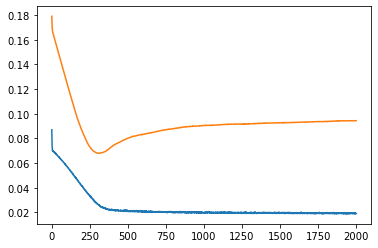

In [11]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend
plt.show()

In [12]:
yhat = model.predict(test_X)

#invert scaling for forecast
yhat = yhat.reshape((630, 1))
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat = inv_yhat.reshape((90, 7))

# invert scaling for actual
test_y = test_y.reshape((630, 1))
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y.reshape((90, 7))

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7940.763


In [13]:
np.std(inv_y)

13938.812

In [14]:
inv_y = inv_y[:, 0]

In [15]:
np.std(inv_y)

14768.888

In [16]:
predict = pemilihan(inv_yhat,inv_y)

In [17]:
rmse = sqrt(mean_squared_error(inv_y, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6240.798


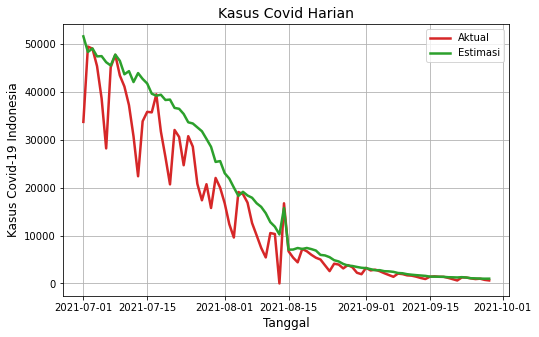

In [18]:
import pandas as pd
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2021-7-01", periods=90)

# membuat frame
fig, ax = plt.subplots(figsize = (8,5))

# membuat time series plot
ax.plot(x, inv_y, color="tab:red", label="Aktual", linewidth=2.5)
ax.plot(x, predict, color="tab:green", label="Estimasi", linewidth=2.5)
#ax.plot(x, inv_yhat, color="tab:blue", label="prediksi", linewidth=2.5)


# membuat label-label
ax.set_title("Kasus Covid Harian", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Kasus Covid-19 Indonesia", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [19]:
train_y = train_y.reshape((3493, 1))
train_y_copies = np.repeat(train_y, 3, axis= -1)
inv_ytrain = scaler.inverse_transform(train_y_copies)
inv_ytrain = inv_ytrain[:,0]
inv_ytrain = inv_ytrain.reshape((499, 7))
inv_ytrain = inv_ytrain[:,0]

In [20]:
evaluasi = model.predict(train_X)

In [21]:
evaluasi = evaluasi.reshape((3493, 1))
evaluasi_copies = np.repeat(evaluasi, 3, axis= -1)
inv_evaluasi = scaler.inverse_transform(evaluasi_copies)
inv_evaluasi = inv_evaluasi[:,0]
inv_evaluasi = inv_evaluasi.reshape((499, 7))
evaluasi = pemilihan(inv_evaluasi, inv_ytrain)

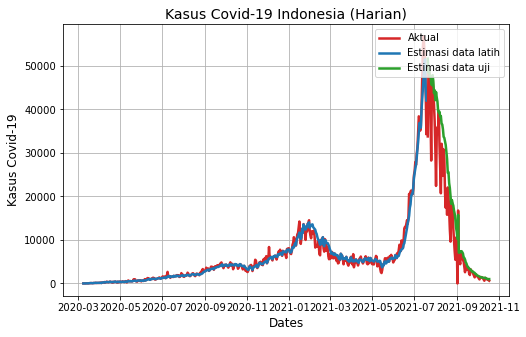

In [22]:
import pandas as pd
# generate urutan data sesuai panjang datanya
x1 = pd.date_range(start="2020-3-9", periods=499)
x2 = pd.date_range(start="2021-7-21", periods=90)

# membuat frame
fig, ax = plt.subplots(figsize = (8,5))

# membuat time series plot
ax.plot(x1, inv_ytrain, color="tab:red", label="Aktual", linewidth=2.5)
ax.plot(x1, evaluasi, color="tab:blue", label="Estimasi data latih", linewidth=2.5)
ax.plot(x2, inv_y, color="tab:red", linewidth=2.5)
ax.plot(x2, predict, color="tab:green", label="Estimasi data uji", linewidth=2.5)

# membuat label-label
ax.set_title("Kasus Covid-19 Indonesia (Harian)", fontsize=14)
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel("Kasus Covid-19", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [23]:
yhat = model.predict(predict_X)

yhat = yhat.reshape((7, 1))
inv_yhat = scaler.inverse_transform(yhat)

predict_y = prediksi_y.reshape((7, 1))
inv_ypredict = scaler.inverse_transform(predict_y)

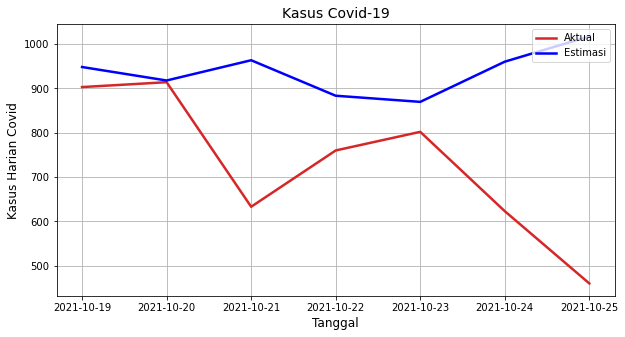

In [28]:
#import pandas as pd

x = pd.date_range(start="2021-10-19", periods=7)

fig, ax = plt.subplots(figsize = (10,5))

ax.plot(x, inv_ypredict, color="tab:red", label="Aktual", linewidth=2.5)
ax.plot(x, inv_yhat, color="Blue", label="Estimasi", linewidth=2.5)

# membuat label-label
ax.set_title("Kasus Covid-19", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Kasus Harian Covid", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
#plt.show()

In [29]:
rmse = sqrt(mean_squared_error(inv_ypredict, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 281.727


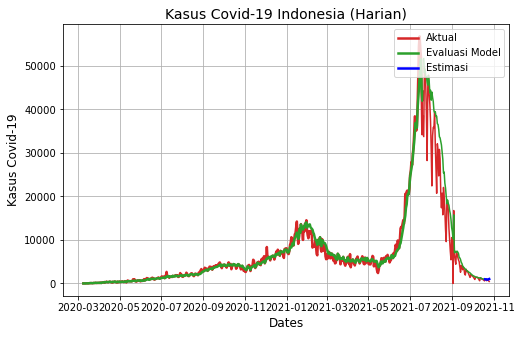

In [26]:
import pandas as pd
# generate urutan data sesuai panjang datanya
x1 = pd.date_range(start="2020-3-9", periods=499)
x2 = pd.date_range(start="2021-7-21", periods=90)
x3 = pd.date_range(start="2021-10-19", periods=7)

# membuat frame
fig, ax = plt.subplots(figsize = (8,5))

# membuat time series plot
ax.plot(x1, inv_ytrain, color="tab:red", label="Aktual", linewidth=2.5)
ax.plot(x1, evaluasi, color="tab:green", label="Evaluasi Model", linewidth=2.5)
ax.plot(x2, inv_y, color="tab:red")
ax.plot(x2, predict, color="tab:green")
ax.plot(x3, inv_ypredict, color="tab:red")
ax.plot(x3, inv_yhat, color="blue", label="Estimasi", linewidth=2.5)

# membuat label-label
ax.set_title("Kasus Covid-19 Indonesia (Harian)", fontsize=14)
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel("Kasus Covid-19", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()